In [ ]:
!pip install xarray netCDF4 matplotlib cartopy

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
# 1. Load datasets
ds_inst = xr.open_dataset('/content/data_stream-oper_stepType-accum.nc')
ds_acc  = xr.open_dataset('/content/data_stream-oper_stepType-accum.nc')

In [4]:
# 2. Inspect dataset contents
print("Instantaneous dataset:")
print(ds_inst)
print("\nAccumulated dataset:")
print(ds_acc)

Instantaneous dataset:
<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 744, latitude: 25, longitude: 19)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2024-08-01 ... 2024-08-31T23:...
  * latitude    (latitude) float64 200B 26.5 26.25 26.0 ... 21.0 20.75 20.5
  * longitude   (longitude) float64 152B 88.0 88.25 88.5 ... 92.0 92.25 92.5
    expver      (valid_time) <U4 12kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 1MB ...
    e           (valid_time, latitude, longitude) float32 1MB ...
    pev         (valid_time, latitude, longitude) float32 1MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-22T11:49 GRIB to CDM+CF via cfgrib-0.9.1...



In [5]:
# 3. Select variables
inst_vars = list(ds_inst.data_vars)
acc_vars  = list(ds_acc.data_vars)
print(f"\nInstantaneous variables: {inst_vars}")
print(f"Accumulated variables: {acc_vars}")


Instantaneous variables: ['tp', 'e', 'pev']
Accumulated variables: ['tp', 'e', 'pev']


In [7]:
# 4. Compute spatial mean time series
inst_mean = ds_inst[inst_vars].mean(dim=['latitude', 'longitude'])
acc_mean  = ds_acc[acc_vars].mean(dim=['latitude', 'longitude'])
# Convert to pandas DataFrame
df_inst = inst_mean.to_dataframe()
df_acc  = acc_mean.to_dataframe()

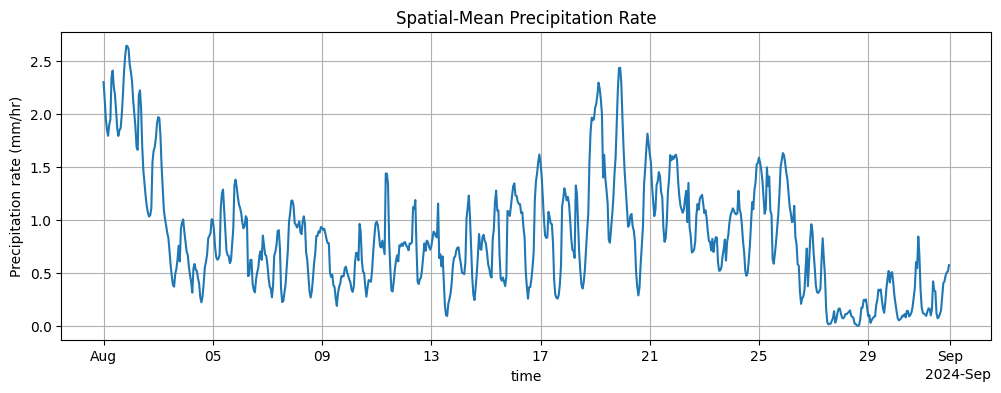

In [52]:
# 1. Rename and convert tp
tp_m = ds_acc['tp']                # in meters of water per time step
tp_mm = tp_m * 1000                # now in mm per time step

# 2. (Optional) Divide by interval to get rate (mm/hr)
#    Here I assume your model outputs every hour; adjust if different.
interval_hours = (ds_acc.valid_time[1] - ds_acc.valid_time[0]).dt.seconds / 3600
tp_rate = tp_mm / interval_hours   # mm per hour

# 3. Compute spatial mean and plot
tp_mean = tp_rate.mean(dim=['latitude','longitude'])

plt.figure(figsize=(12,4))
tp_mean.plot()
plt.ylabel('Precipitation rate (mm/hr)')
plt.title('Spatial‐Mean Precipitation Rate')
plt.grid(True)
plt.show()


In [13]:
# --- 1) Convert instantaneous fields to mm per step or mm/hr as needed ---
dt_hours = (ds_inst.valid_time[1] - ds_inst.valid_time[0]).dt.seconds / 3600

In [53]:
# Instantaneous: tp, e, pev
ds_inst['tp_rate'] = (ds_inst['tp'] * 1000) / dt_hours      # tp: m → mm, then per hour
ds_inst['e_rate']  = (ds_inst['e']  * 1000) / dt_hours      # e: m → mm per hour
ds_inst['pev_rate']= (ds_inst['pev']* 1000) / dt_hours      # pev: m → mm per hour

for v in ['tp_rate','e_rate','pev_rate']:
    ds_inst[v].attrs['units'] = 'mm/hr'

# Already have accumulated in mm per step as tp_mm
# Do the same for e and pev
ds_acc['e_mm']   = ds_acc['e']   * 1000
ds_acc['pev_mm'] = ds_acc['pev'] * 1000
ds_acc['tp_mm']  = tp_mm  # from your earlier code

for v in ['tp_mm','e_mm','pev_mm']:
    ds_acc[v].attrs['units'] = 'mm'


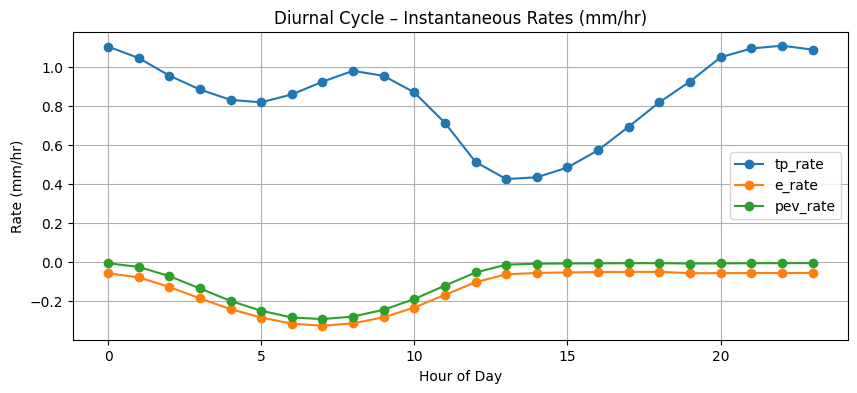

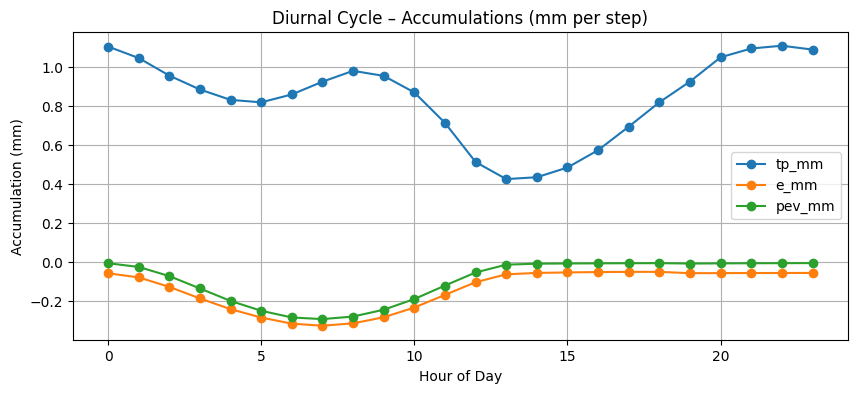

In [56]:
# --- 2) Diurnal cycle of rates and accumulations ---
hourly_inst = ds_inst[['tp_rate','e_rate','pev_rate']].groupby('valid_time.hour').mean(dim=['valid_time','latitude','longitude'])
hourly_acc  = ds_acc[['tp_mm','e_mm','pev_mm']].groupby('valid_time.hour').mean(dim=['valid_time','latitude','longitude'])

plt.figure(figsize=(10,4))
for v in hourly_inst:
    plt.plot(hourly_inst.hour, hourly_inst[v], marker='o', label=v)
plt.title('Diurnal Cycle – Instantaneous Rates (mm/hr)')
plt.xlabel('Hour of Day')
plt.ylabel('Rate (mm/hr)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
for v in hourly_acc:
    plt.plot(hourly_acc.hour, hourly_acc[v], marker='o', label=v)
plt.title('Diurnal Cycle – Accumulations (mm per step)')
plt.xlabel('Hour of Day')
plt.ylabel('Accumulation (mm)')
plt.legend()
plt.grid(True)
plt.show()

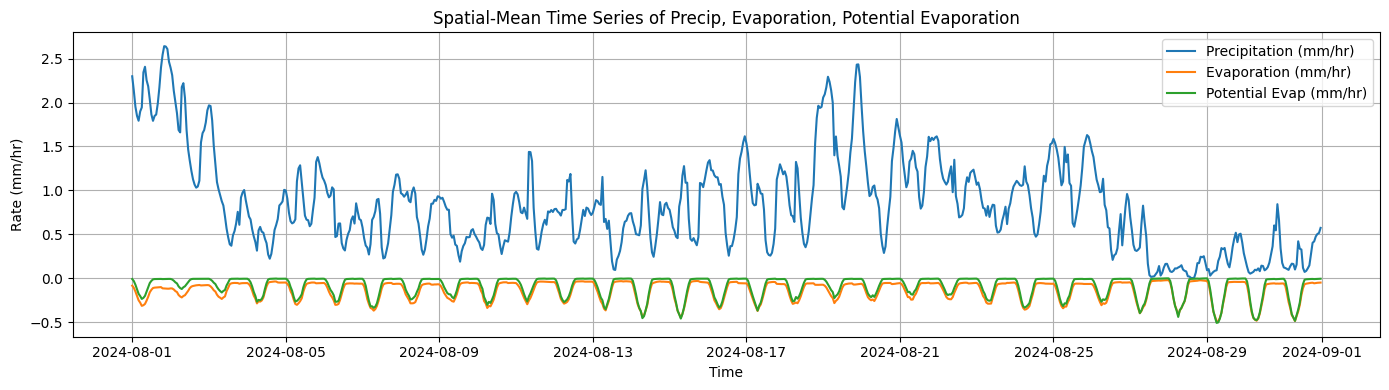

In [55]:
# 1) Compute the domain-average time series for each variable
ts_tp  = ds_inst['tp_rate'].mean(dim=['latitude','longitude']).to_series()
ts_e   = ds_inst['e_rate'].mean(dim=['latitude','longitude']).to_series()
ts_pev = ds_inst['pev_rate'].mean(dim=['latitude','longitude']).to_series()

# 2) Combine into a single DataFrame
df_ts = pd.concat([ts_tp, ts_e, ts_pev], axis=1)
df_ts.columns = ['Precipitation (mm/hr)', 'Evaporation (mm/hr)', 'Potential Evap (mm/hr)']

# 3) Plot
plt.figure(figsize=(14,4))
for col in df_ts.columns:
    plt.plot(df_ts.index, df_ts[col], label=col)
plt.legend(loc='upper right')
plt.title('Spatial-Mean Time Series of Precip, Evaporation, Potential Evaporation')
plt.xlabel('Time')
plt.ylabel('Rate (mm/hr)')
plt.grid(True)
plt.tight_layout()
plt.show()

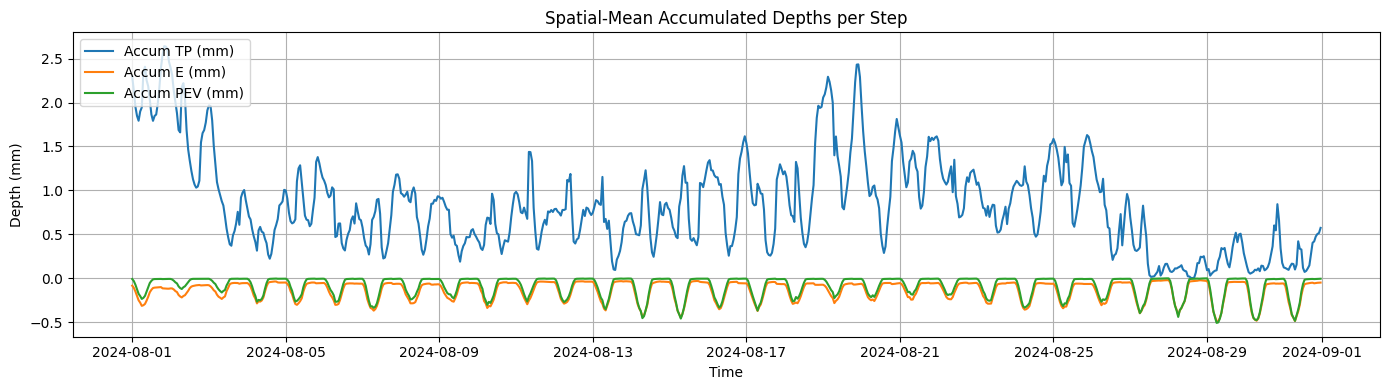

In [34]:
ts_tp_acc  = ds_acc['tp_mm'].mean(dim=['latitude','longitude']).to_series()
ts_e_acc   = ds_acc['e_mm'].mean(dim=['latitude','longitude']).to_series()
ts_pev_acc = ds_acc['pev_mm'].mean(dim=['latitude','longitude']).to_series()

df_acc = pd.concat([ts_tp_acc, ts_e_acc, ts_pev_acc], axis=1)
df_acc.columns = ['Accum TP (mm)', 'Accum E (mm)', 'Accum PEV (mm)']

plt.figure(figsize=(14,4))
for col in df_acc.columns:
    plt.plot(df_acc.index, df_acc[col], label=col)
plt.legend(loc='upper left')
plt.title('Spatial-Mean Accumulated Depths per Step')
plt.xlabel('Time')
plt.ylabel('Depth (mm)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
import seaborn as sns

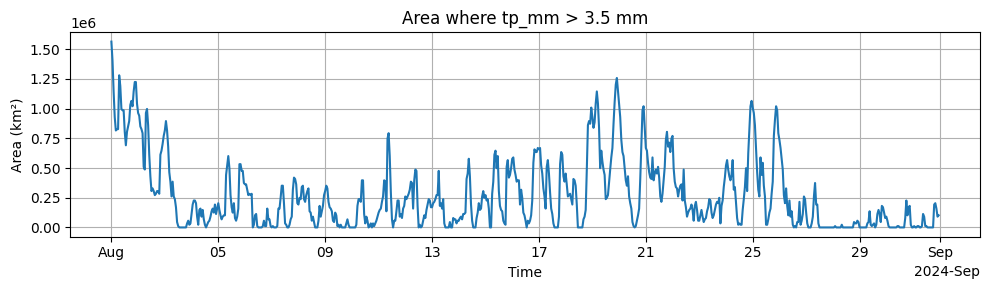

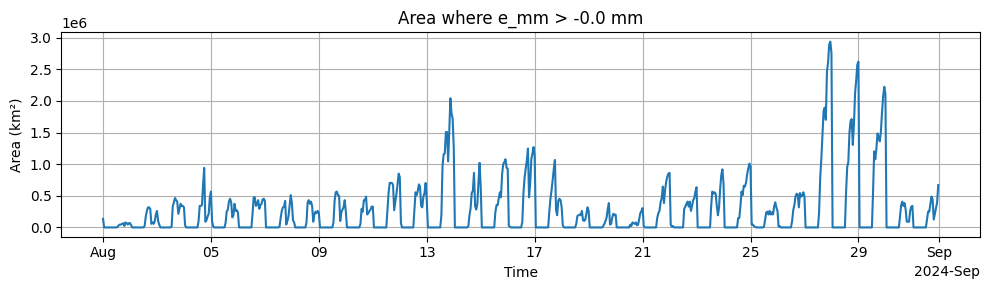

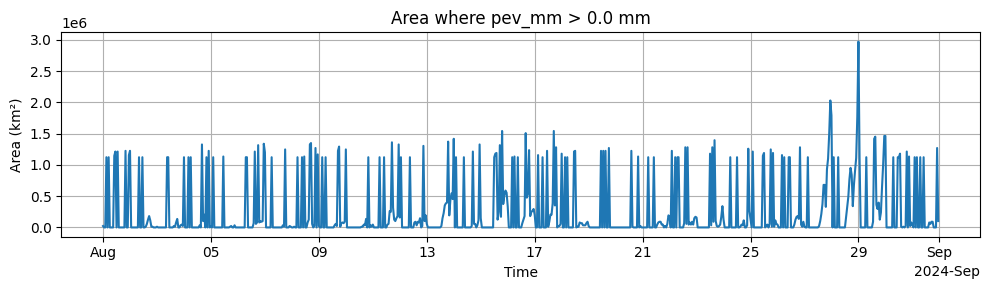

In [26]:
# 1) Compute 1°×1° cell area at the domain’s mean latitude
mean_lat = float(ds_acc.latitude.mean())
earth_radius = 6371  # in km
dy = np.deg2rad(1) * earth_radius
dx = np.deg2rad(1) * earth_radius * np.cos(np.deg2rad(mean_lat))
cell_area_km2 = dx * dy  # km² per 1°×1° cell

# 2) Loop over your accumulation variables
for var in ['tp_mm', 'e_mm', 'pev_mm']:
    # a) 95th-percentile threshold
    q95 = ds_acc[var].quantile(0.95)

    # b) Boolean mask of “extreme” grid-points at each time
    events = ds_acc[var] > q95

    # c) Number of grid-points exceeding threshold
    count = events.sum(dim=['latitude','longitude'])

    # d) Convert count → approximate area
    area_km2 = count * cell_area_km2

    # e) Plot the time-series of area
    plt.figure(figsize=(10,3))
    area_km2.plot()
    plt.ylabel('Area (km²)')
    plt.xlabel('Time')
    plt.title(f'Area where {var} > {q95.values:.1f} mm')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

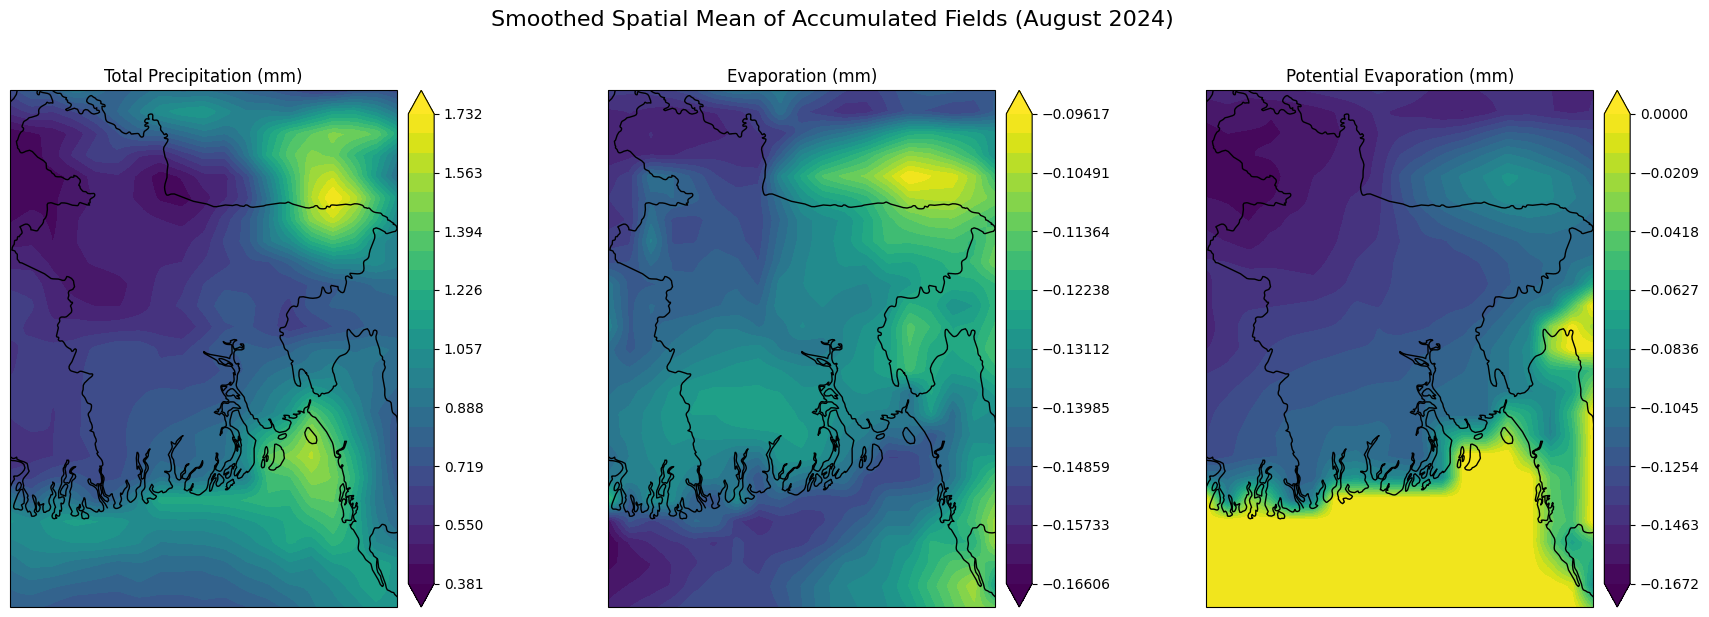

In [40]:
# --- 6) Map: spatial mean of total precipitation accumulation ---
# 1) Extract scalar bounds
lon_min = float(ds_acc.longitude.min())
lon_max = float(ds_acc.longitude.max())
lat_min = float(ds_acc.latitude.min())
lat_max = float(ds_acc.latitude.max())

# 2) Define a finer grid
new_lons = np.linspace(lon_min, lon_max, 200)
new_lats = np.linspace(lat_min, lat_max, 200)

vars_mm = ['tp_mm', 'e_mm', 'pev_mm']
titles  = ['Total Precipitation (mm)', 'Evaporation (mm)', 'Potential Evaporation (mm)']

fig, axes = plt.subplots(
    1, 3, figsize=(18, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

for ax, var, title in zip(axes, vars_mm, titles):
    # Compute the time‐mean
    mean_map = ds_acc[var].mean(dim='valid_time')

    # Interpolate onto finer grid
    mean_hr = mean_map.interp(longitude=new_lons, latitude=new_lats)

    # Contour‐filled plot for smoothness
    levels = np.linspace(
        float(mean_hr.min()),
        float(mean_hr.max()),
        25
    )
    cfplot = ax.contourf(
        new_lons, new_lats, mean_hr,
        levels=levels,
        transform=ccrs.PlateCarree(),
        cmap='viridis',
        extend='both'
    )

    # Add coastlines and borders
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS.with_scale('10m'))
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Colorbar
    cbar = fig.colorbar(cfplot, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label(mean_map.attrs.get('units', ''))

plt.suptitle('Smoothed Spatial Mean of Accumulated Fields (August 2024)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [41]:
from sklearn.decomposition import PCA

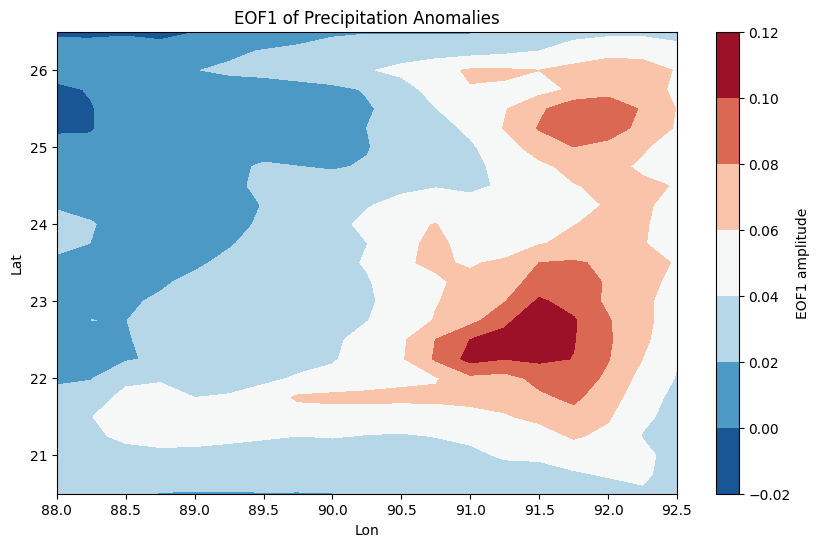

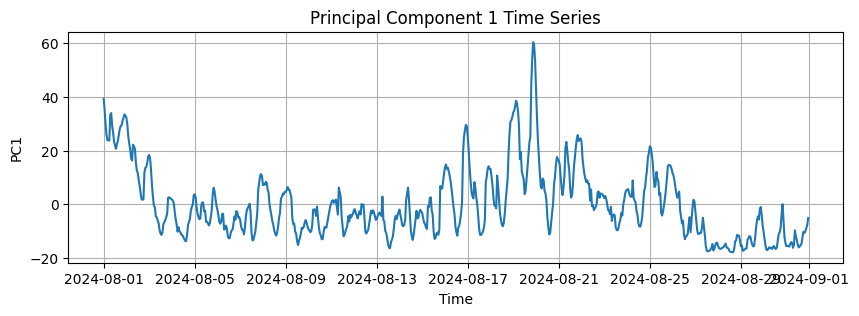

In [59]:
# 1) Grab precipitation anomalies (tp_mm minus its time mean)
tp = ds_acc['tp_mm']
tp_anom = tp - tp.mean(dim='valid_time')

# 2) Reshape to (time, space)
nt, ny, nx = tp_anom.shape
X = tp_anom.values.reshape(nt, ny*nx)

# 3) Run PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(X)    # shape (time, 2)
eofs = pca.components_.reshape(2, ny, nx)

# 4) Plot EOF1 spatial pattern
plt.figure(figsize=(10,6))
plt.contourf(ds_acc.longitude, ds_acc.latitude, eofs[0], cmap='RdBu_r')
plt.colorbar(label='EOF1 amplitude')
plt.title('EOF1 of Precipitation Anomalies')
plt.xlabel('Lon'); plt.ylabel('Lat')
plt.show()

# 5) Plot the PC1 time series
plt.figure(figsize=(10,3))
plt.plot(ds_acc.valid_time, pcs[:,0])
plt.title('Principal Component 1 Time Series')
plt.ylabel('PC1'); plt.xlabel('Time')
plt.grid(True)
plt.show()

Top 10 rainy days (date → mean rainfall in mm):
valid_time
2024-08-01    51.920525
2024-08-19    40.913120
2024-08-02    40.182770
2024-08-21    31.575699
2024-08-25    29.461472
2024-08-22    26.137503
2024-08-20    25.884766
2024-08-18    24.634485
2024-08-24    24.116444
2024-08-16    23.218513
Name: tp_mm, dtype: float32


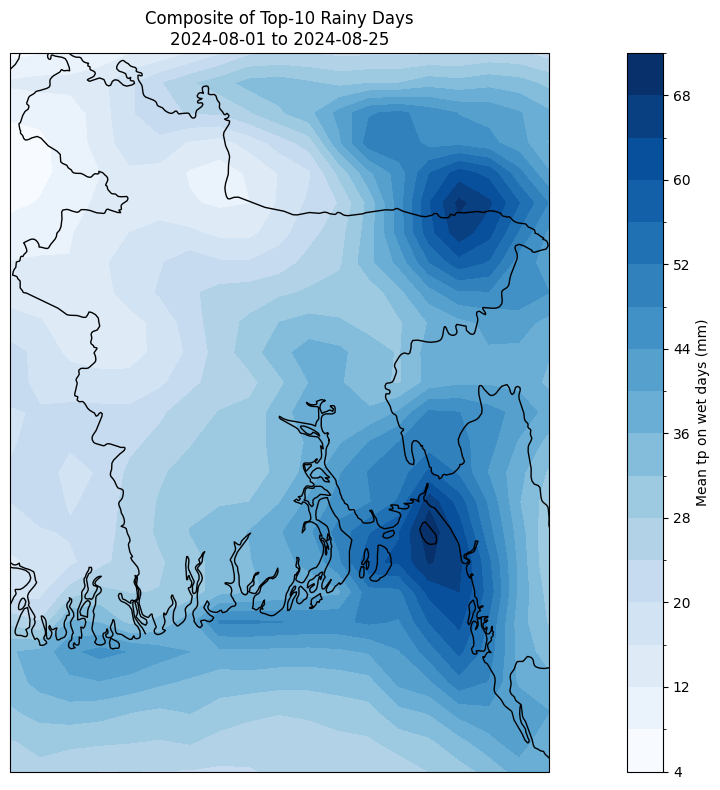

In [57]:
# 1) Build the pandas Series of daily domain-mean precipitation
daily_tp = ds_acc['tp_mm'].resample(valid_time='1D').sum(dim='valid_time')
daily_mean = daily_tp.mean(dim=['latitude','longitude']).to_series()

# 2) Show the top-10 rainy days
top10 = daily_mean.nlargest(10)
print("Top 10 rainy days (date → mean rainfall in mm):")
print(top10)

# 3) Use those exact dates for the composite
wet_days = top10.index

# 4) Composite map
composite = daily_tp.sel(valid_time=wet_days).mean(dim='valid_time')

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.PlateCarree())
im = composite.plot.contourf(
    ax=ax, levels=20, cmap='Blues',
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label': 'Mean tp on wet days (mm)'}
)
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS.with_scale('10m'))
ax.set_title('Composite of Top-10 Rainy Days\n'+
             f"{wet_days.min().strftime('%Y-%m-%d')} to {wet_days.max().strftime('%Y-%m-%d')}")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

Max correlation at lag = 65 time steps (65 hr)


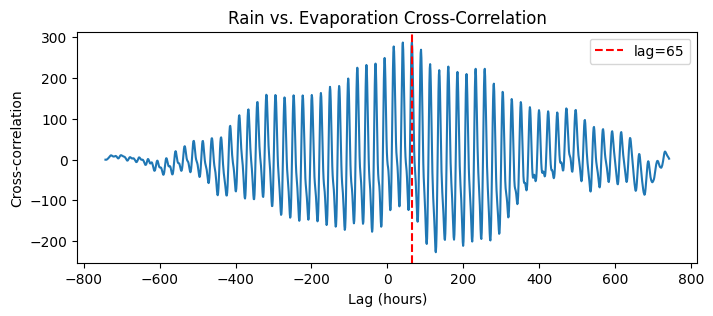

In [45]:
from scipy.signal import correlate

# Spatial mean timeseries
tp_ts  = ds_inst['tp_rate'].mean(dim=['latitude','longitude']).values
e_ts   = ds_inst['e_rate'].mean(dim=['latitude','longitude']).values

# Remove mean, normalize
tp0 = (tp_ts - tp_ts.mean())/tp_ts.std()
e0  = (e_ts  - e_ts.mean()) /e_ts.std()

# Full cross‐correlation
xc = correlate(e0, tp0, mode='full')
lags = np.arange(-len(tp0)+1, len(tp0))
best_lag = lags[np.argmax(xc)]

print(f"Max correlation at lag = {best_lag} time steps ({best_lag} hr)")

plt.figure(figsize=(8,3))
plt.plot(lags, xc)
plt.axvline(best_lag, color='r', linestyle='--', label=f'lag={best_lag}')
plt.xlabel('Lag (hours)')
plt.ylabel('Cross‐correlation')
plt.title('Rain vs. Evaporation Cross‐Correlation')
plt.legend()
plt.show()